In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
labels = {
    0: 'dress',
    1: 'hat',
    2: 'longsleeve',
    3: 'outwear',
    4: 'pants',
    5: 'shirt',
    6: 'shoes',
    7: 'shorts',
    8: 'skirt',
    9: 't-shirt'
}

## Big model

First, we'll test the big model trained on `299x299` pictures.

You can either use your own model, or download the one we trained for the book:

        wget https://github.com/alexeygrigorev/mlbookcamp-code/releases/download/chapter7-model/xception_v4_large_08_0.894.h5

In [5]:
image_size = (299, 299)

In [23]:
!git clone https://github.com/alexeygrigorev/clothing-dataset.git

Cloning into 'clothing-dataset'...
Updating files:  11% (691/5759)
Updating files:  12% (692/5759)
Updating files:  13% (749/5759)
Updating files:  14% (807/5759)
Updating files:  15% (864/5759)
Updating files:  16% (922/5759)
Updating files:  17% (980/5759)
Updating files:  18% (1037/5759)
Updating files:  19% (1095/5759)
Updating files:  20% (1152/5759)
Updating files:  21% (1210/5759)
Updating files:  22% (1267/5759)
Updating files:  22% (1274/5759)
Updating files:  23% (1325/5759)
Updating files:  24% (1383/5759)
Updating files:  25% (1440/5759)
Updating files:  26% (1498/5759)
Updating files:  27% (1555/5759)
Updating files:  28% (1613/5759)
Updating files:  29% (1671/5759)
Updating files:  30% (1728/5759)
Updating files:  31% (1786/5759)
Updating files:  32% (1843/5759)
Updating files:  33% (1901/5759)
Updating files:  34% (1959/5759)
Updating files:  34% (1997/5759)
Updating files:  35% (2016/5759)
Updating files:  36% (2074/5759)
Updating files:  37% (2131/5759)
Updating files:

In [24]:
model = keras.models.load_model('xception_v4_large_08_0.894.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'xception_v4_large_08_0.894.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [10]:
# Make a function to create a CNN
def make_model(input_size = 150, learning_rate = 0.01, size_inner = 100, droprate = 0.5):
    # Initialize Xception model
    base_model = Xception(
        weights = 'imagenet',
        include_top = False,
        input_shape = (input_size, input_size, 3)
    )
    # Frozen model's weights
    base_model.trainable = False

    #########################################

    # Specify the inputs (part of the model that receives the images)
    inputs = keras.Input(shape = (input_size, input_size, 3))
    # Apply the base model to inputs to get base
    base = base_model(inputs, training = False)
    # Average Pooling layer to reduce the dimensionality
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    # Add an inner layer
    inner = keras.layers.Dense(size_inner, activation = 'relu')(vectors)
    # Add dropout
    drop = keras.layers.Dropout(droprate)(inner)
    # Dense layers for the output
    outputs = keras.layers.Dense(10)(drop)
    # model
    model = keras.Model(inputs, outputs)

    #########################################
    # Set the optimizer
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    # Set the loss function
    loss = keras.losses.CategoricalCrossentropy(from_logits = True)
    
    # Compile everything in our model, setting optimizer, loss, and metric's evaluation
    model.compile(
        optimizer = optimizer,
        loss = loss,
        metrics = ['accuracy']
    )

    # return model
    return model

In [11]:
# Set input image size
input_size = 299

In [12]:
# Initialize training data generator
train_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    shear_range = 10,
    zoom_range = 0.1,
    horizontal_flip = True
)
# Extract training images
train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size = (input_size, input_size),
    batch_size = 32
)

# Initialize validation data generator
val_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
# Extract validation images
val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size = (input_size, input_size),
    batch_size = 32,
    shuffle = False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [13]:
# Checkpoint to save the model
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only = True,
    monitor = 'val_accuracy',
    mode = 'max'
)

In [14]:
# Set the learning rate
learning_rate = 0.0005
# Set the inner layer size
size = 100
# Set the dropout rate
droprate = 0.2

# Build the model
model = make_model(
    input_size = input_size,
    learning_rate = learning_rate,
    size_inner = size,
    droprate = droprate
)

# Model training
history = model.fit(train_ds, epochs = 50, validation_data = val_ds, callbacks=[checkpoint])

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 839s 9s/step - accuracy: 0.6724 - loss: 1.0170 - val_accuracy: 0.8387 - val_loss: 0.5269
Epoch 2/50
69/96 ━━━━━━━━━━━━━━━━━━━━ 2:48 6s/step - accuracy: 0.8050 - loss: 0.5670


KeyboardInterrupt



## 8.12 Using the model

* Loading the model
* Evaluating the model
* Getting predictions

In [15]:
# Import numpy, tensorflow and keras for images
import numpy as np
import tensorflow as tf
from tensorflow import keras

# load function to process data for the xception model
from tensorflow.keras.applications.xception import preprocess_input

# import function to extract images for datasets and also to read images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

In [16]:
# Set input image size
input_size = 299
# Initialize test data generator
test_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
# Extract test images
test_ds = test_gen.flow_from_directory(
    './clothing-dataset-small/test',
    target_size = (input_size, input_size),
    batch_size = 32,
    shuffle = False
)

Found 373 images belonging to 10 classes.


In [17]:
# Load the best model by file
model = keras.models.load_model('xception_v4_1_38_0.894.keras')

# Evaluate model on test data
model.evaluate(test_ds)

ValueError: File not found: filepath=xception_v4_1_38_0.894.keras. Please ensure the file is an accessible `.keras` zip file.

The loss is very small, and the accuracy is more than 90%
. The scores are very close to what was sseen on the validation data, showing that the model generalizes well

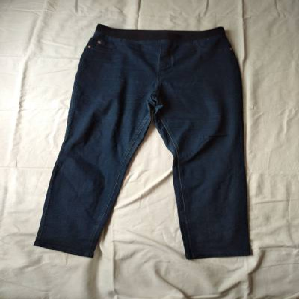

In [18]:
# Path to an image
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'
# Load the image
img = load_img(path, target_size = (input_size, input_size))
# show the image
img

In [19]:
# Convert the image to an array
x = np.array(img)
# Get a batch of one image as array
X = np.array([x])
# Shape of a batch of one image
X.shape

(1, 299, 299, 3)

In [20]:
# Preprocess a batch of one image
X = preprocess_input(X)

# Model's prediction
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [21]:
# Target classes (no need to map, as this list is already sequential)
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

# Target classes with predictions
dict(zip(classes, pred[0]))

{'dress': np.float32(-1.4736004),
 'hat': np.float32(-2.2649875),
 'longsleeve': np.float32(-0.51724815),
 'outwear': np.float32(-1.0418589),
 'pants': np.float32(6.9601507),
 'shirt': np.float32(-0.47689486),
 'shoes': np.float32(-1.8595473),
 'shorts': np.float32(2.5787914),
 'skirt': np.float32(-1.298287),
 't-shirt': np.float32(-1.8338841)}

The higher score is the one of `pants`: the model prediction is **correct**.

## 8.13 Summary

* We can use pre-trained models for general image classification
* Convolutional layers let us turn an image into a vector
* Dense layers use the vector to make the predictions
* Instead of training a model from scratch, we can use transfer learning and re-use already trained convolutional layers
* First, train a small model (150x150) before training a big one (299x299)
* Learning rate - how fast the model trians. Fast learners aren't always best ones
* We can save the best model using callbacks and checkpointing
* To avoid overfitting, use dropout and augmentation


## 8.14 Explore more

* Add more data, e.g. Zalando, etc (ADD LINKS)
* Albumentations - another way of generating augmentations
* Use PyTorch or MXNet instead of TensorFlow/Keras
* In addition to Xception, there are others architectures - try them


Other projects:

* cats vs dogs
* Hotdog vs not hotdog
* Category of images